In [ ]:
# Import necessary libraries
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load dataset
df = pd.read_csv('/content/classified_tweet (2).csv')  # Replace with your dataset

# Preprocess the dataset
df['Tweet'] = df['Tweet'].astype(str)  # Convert all tweets to strings
df['Tweet'].fillna('', inplace=True)    # Replace any missing values with empty strings

# Encode labels
label_encoder = LabelEncoder()
df['Classification'] = label_encoder.fit_transform(df['Classification'])

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Tweet'].tolist(),
    df['Classification'].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert to torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are long integers
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

# Load the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Define compute_metrics function to calculate accuracy, precision, recall, and F1-score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',            # output directory
    num_train_epochs=5,                # reduce to 1 epoch
    per_device_train_batch_size=8,     # reduce batch size to 8
    per_device_eval_batch_size=8,      # reduce eval batch size
    warmup_steps=500,                  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # strength of weight decay
    logging_dir='./logs',              # directory for storing logs
    logging_steps=10,                  # log every 10 steps
    evaluation_strategy="epoch",       # evaluate at the end of each epoch
    fp16=True,                         # enable mixed precision training
)

# Define the Trainer
trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments
    train_dataset=train_dataset,        # training dataset
    eval_dataset=val_dataset,           # evaluation dataset
    compute_metrics=compute_metrics     # compute metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Print the evaluation results (accuracy, precision, recall, F1-score)
print(f"Accuracy: {results['eval_accuracy']}")
print(f"Precision: {results['eval_precision']}")
print(f"Recall: {results['eval_recall']}")
print(f"F1-Score: {results['eval_f1']}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.280000,0.372466,0.867806,0.868773,0.870975,0.867806
2,0.307000,0.368392,0.899046,0.897048,0.897329,0.899046
3,0.253700,0.415598,0.920327,0.919976,0.920056,0.920327
4,0.091600,0.454541,0.929448,0.928704,0.928463,0.929448
5,0.125400,0.517507,0.927875,0.927980,0.928119,0.927875


Accuracy: 0.9278750393122969
Precision: 0.9281191111984731
Recall: 0.9278750393122969
F1-Score: 0.9279800970260113


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot accuracy and loss graphs
def plot_training_history(trainer):
    # Retrieve the training log history
    logs = pd.DataFrame(trainer.state.log_history)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    if 'eval_accuracy' in logs.columns:
        plt.plot(logs['epoch'], logs['eval_accuracy'], label='Validation Accuracy', color="orange")
    else:
        print("'eval_accuracy' not found in logs.")

    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.0)  # Adjusting limits based on typical accuracy range
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    if 'loss' in logs.columns:
        plt.plot(logs['epoch'], logs['loss'], label='Train Loss', color="blue")
    if 'eval_loss' in logs.columns:
        plt.plot(logs['epoch'], logs['eval_loss'], label='Validation Loss', color="orange")

    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1.5)  # Adjusting limits based on typical loss range
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(trainer)


In [ ]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred_classes):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# Multi-Class ROC Curve
def plot_roc_curve(y_test, y_pred_classes, num_classes):
    # Binarize the output labels for multi-class ROC
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    y_pred_bin = label_binarize(y_pred_classes, classes=np.arange(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'orange', 'red']
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve class {i} (area = {roc_auc[i]:.2f})')

    # Plot random chance line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Configure plot aesthetics
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


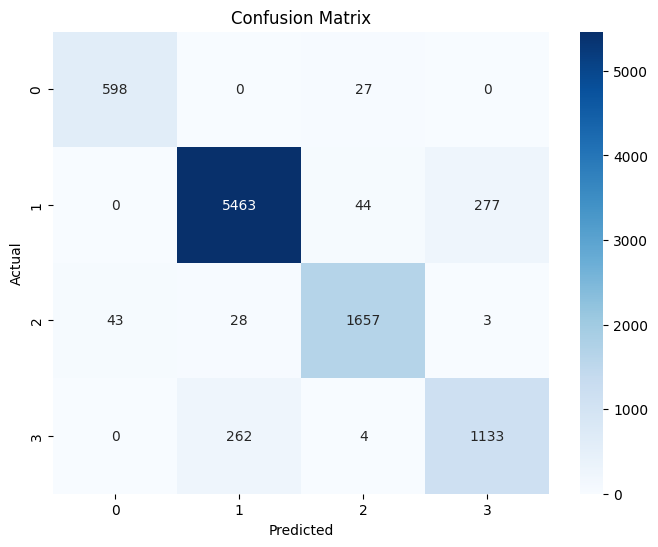

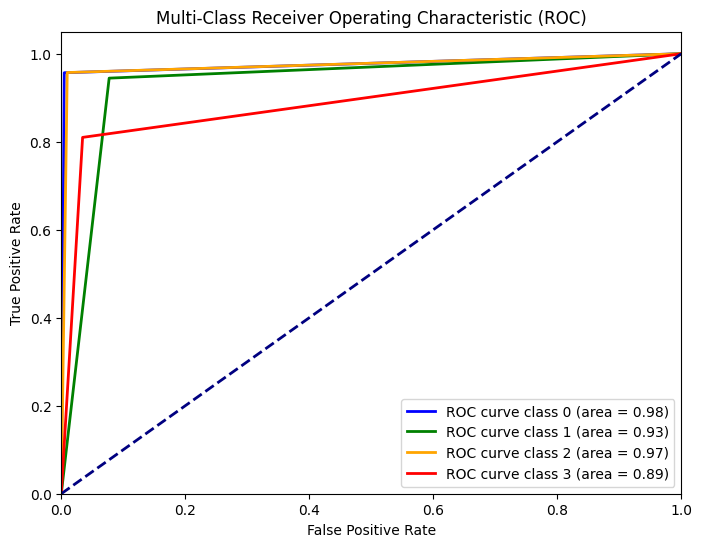

In [ ]:
# Assuming y_test and y_pred_classes are already available from the evaluation phase.

# Plot confusion matrix
y_test = val_labels  # Ground truth labels from validation set
y_pred_classes = trainer.predict(val_dataset).predictions.argmax(-1)  # Get predicted classes

plot_confusion_matrix(y_test, y_pred_classes)

# Plot multi-class ROC curve (assuming 4 classes in this case)
plot_roc_curve(y_test, y_pred_classes, num_classes=4)
